## 載套件 並且固定random seed

In [160]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.decomposition import PCA
# 設定隨機種子
seed_value = 42
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed(seed_value)


# 確保在使用 CUDA 時的確定性
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 前處理數據

In [161]:
# 讀取資料
data = pd.read_excel('C:/Users/fishd/Desktop/Github/FTIR_dust/dataset/FTIR(調基準線).xlsx')

### 取出訓練資料 與模擬未來新加入的資料

In [162]:
old_data = data.iloc[:,:-1]
new_data = data.iloc[-1,:-1]
print(old_data.shape,new_data.shape)
old_data=old_data.to_numpy() 
new_data=new_data.to_numpy() #Series 2 numpy
new_data=new_data.reshape(1,-1)# trun 
print(old_data.shape,new_data.shape)


(592, 3351) (3351,)
(592, 3351) (1, 3351)


### PCA

In [163]:
pca = PCA(n_components=100)
X_pca = pca.fit_transform(old_data)
features = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
features.head()


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC91,PC92,PC93,PC94,PC95,PC96,PC97,PC98,PC99,PC100
0,61.867154,-5.593633,7.646167,-25.809740,20.733466,-1.672207,3.824107,0.642715,-3.220496,3.571545,...,0.000235,-0.002135,0.046245,-0.012589,0.012981,-0.066806,0.021817,0.015743,-0.044410,-0.103419
1,-94.169060,-15.298427,11.775053,-20.444210,24.781940,7.536172,0.849146,-2.506871,-1.427969,2.118270,...,-0.005992,0.047954,-0.026884,0.004110,0.024584,-0.028232,-0.015966,-0.020704,0.009048,0.030530
2,170.968178,12.799292,-7.988993,6.551230,-2.633998,2.149236,-0.333459,-0.286926,0.057677,-0.864333,...,0.044676,-0.061633,-0.107109,-0.008689,-0.073835,0.017642,0.009791,-0.068015,-0.004353,0.076457
3,29.529533,-5.067870,-3.917339,3.550551,-6.876736,9.459210,-0.910147,-0.857171,-3.451889,-1.745772,...,-0.000543,-0.052192,0.002512,0.013727,-0.041354,0.041285,-0.027130,-0.050934,0.025027,0.051337
4,57.198914,-6.650748,-10.348528,7.420508,-2.479917,9.949265,1.593086,-0.591014,-4.332213,-3.143374,...,-0.004712,-0.015459,-0.017931,-0.024855,-0.052111,0.040761,0.017316,0.052422,0.026019,0.012161


In [164]:
new_pca = pca.transform(new_data)
new_features = pd.DataFrame(new_pca, columns=[f'PC{i+1}' for i in range(new_pca.shape[1])])
new_features.head() # 

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC91,PC92,PC93,PC94,PC95,PC96,PC97,PC98,PC99,PC100
0,145.794606,11.325318,-11.004011,-0.169259,4.556719,-0.509492,0.098117,0.471578,1.572214,-0.621784,...,-0.009916,-0.001896,0.029148,-0.044403,-0.009295,-0.001519,-0.008911,0.020421,0.050546,0.022132


In [165]:
target = data.iloc[:, -1]
target.shape

(592,)

In [166]:
# 分割訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=seed_value)


### 特徵標準化

In [167]:
# 特徵標準化
scaler = StandardScaler()
X_train_np = scaler.fit_transform(X_train).reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_np = scaler.transform(X_test).reshape((X_test.shape[0], 1, X_test.shape[1]))

y_train_np = y_train.to_numpy() if isinstance(y_train, pd.Series) else y_train
y_test_np = y_test.to_numpy() if isinstance(y_test, pd.Series) else y_test

## MODEL

In [168]:
# 設定 DataLoader
batch_size = 64
train_dataset = TensorDataset(torch.tensor(X_train_np, dtype=torch.float32), torch.tensor(y_train_np, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test_np, dtype=torch.float32), torch.tensor(y_test_np, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 建立 CNN 模型
class CNNRegressor(nn.Module):
    def __init__(self, input_shape):
        super(CNNRegressor, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=7, padding=3)
        self.pool1 = nn.MaxPool1d(kernel_size=3)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * (input_shape // 6), 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# 創建模型
input_shape = X_train_np.shape[2]
model = CNNRegressor(input_shape).to(device)

In [169]:
# 編譯模型
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.L1Loss()

## TRAIN

In [170]:
from tqdm import tqdm
# 訓練模型
epochs = 200
model.train()
train_losses = []
val_losses = []

for epoch in tqdm(range(epochs), desc=f"Train epochs {epochs}"):
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs.flatten(), y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # 驗證損失
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs.flatten(), y_batch)
            val_loss += loss.item() * X_batch.size(0)

    val_loss /= len(test_loader.dataset)
    val_losses.append(val_loss)
    model.train()



Train epochs 200: 100%|██████████| 200/200 [00:06<00:00, 33.18it/s]


## verify

In [171]:
# 評估模型
model.eval()
with torch.no_grad():
    y_pred_train = model(torch.tensor(X_train_np, dtype=torch.float32).to(device)).cpu().numpy().flatten()
    y_pred_test = model(torch.tensor(X_test_np, dtype=torch.float32).to(device)).cpu().numpy().flatten()

train_mse = mean_squared_error(y_train_np, y_pred_train)
train_r2 = r2_score(y_train_np, y_pred_train)
test_mse = mean_squared_error(y_test_np, y_pred_test)
test_r2 = r2_score(y_test_np, y_pred_test)

print(f'train MSE: {train_mse}, train R²: {train_r2}')
print(f'test MSE: {test_mse}, test R²: {test_r2}')

train MSE: 0.07686781778979077, train R²: 0.8082386786498343
test MSE: 0.08839703158095286, test R²: 0.5284812180629368


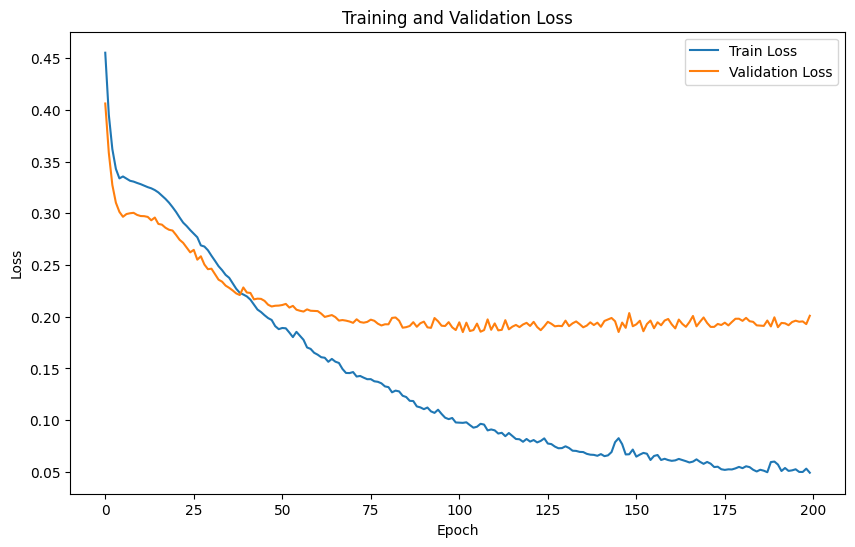

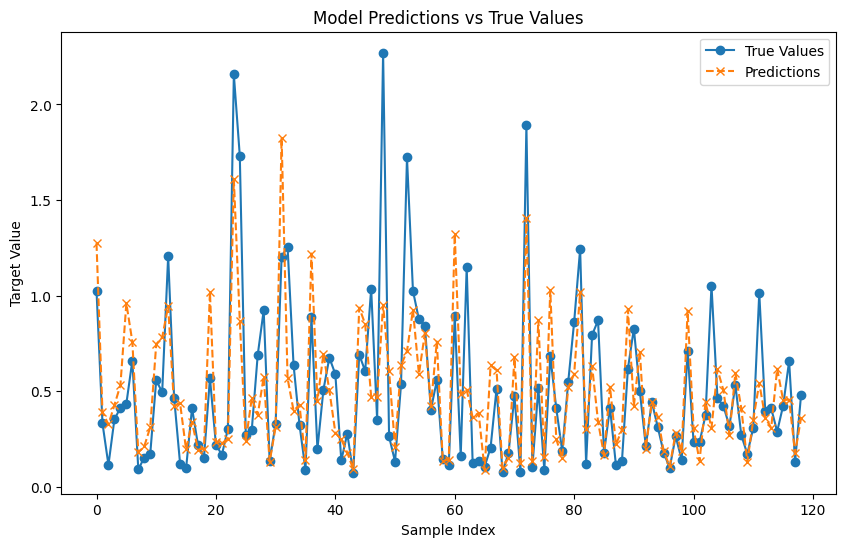

In [173]:
# 繪製訓練和驗證損失曲線
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()

# 繪製預測結果與真實值的比較
plt.figure(figsize=(10, 6))
plt.plot(y_test_np, label='True Values', marker='o')
plt.plot(y_pred_test, label='Predictions', linestyle='--', marker='x')
plt.legend()
plt.xlabel('Sample Index')
plt.ylabel('Target Value')
plt.title('Model Predictions vs True Values')
plt.show()
